In [ ]:
!pip install utils datasets numpy scipy seaborn matplotlib gdown

In [ ]:
from helper_functions.get_collected_data import *
import scipy.io

x = GetEMGData("Collected_Data/Subject_1/WA_thumb.mat")
for i in x:
    print(i.shape)

# for i in dy[7][0][0][3][0]:
#   print(i.item())

# for i in dy[6][0][0][5][0]:
#   print(i.item())

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from utils import *

import datasets
from datasets import load_dataset, load_metric

import scipy
import numpy as np
import pandas as pd

import pickle
import gdown
import os

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [5]:
def load_data_from_drive(file_url, output_path):
    # Extract file ID from URL
    file_id = file_url.split("/d/")[1].split("/view")[0]

    # Construct download link
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Download file
    gdown.download(download_url, output_path, quiet=False)

# Load the data from my drive
load_data_from_drive("https://drive.google.com/file/d/1bhrvIGgsKgndZZeNOoXaOIZU8WqyN3in/view?usp=drive_link", "E1.mat")
load_data_from_drive("https://drive.google.com/file/d/1aW7bYXEzp_0hytdizV_oo5n7C8woPlz6/view?usp=drive_link", "E2.mat")

Downloading...
From: https://drive.google.com/uc?id=1bhrvIGgsKgndZZeNOoXaOIZU8WqyN3in
To: /content/E1.mat
100%|██████████| 151M/151M [00:01<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aW7bYXEzp_0hytdizV_oo5n7C8woPlz6
To: /content/E2.mat
100%|██████████| 244M/244M [00:02<00:00, 91.1MB/s]


In [4]:
# Import the data
df1 = scipy.io.loadmat("E1.mat")
df2 = scipy.io.loadmat("E2.mat")

emg1 = pd.DataFrame(df1["emg"])
emg2 = pd.DataFrame(df2["emg"])

acc1 = pd.DataFrame(df1["acc"])
acc2 = pd.DataFrame(df2["acc"])

glove1 = pd.DataFrame(df1["glove"])
glove2 = pd.DataFrame(df2["glove"])

stimulus1 = pd.DataFrame(df1["stimulus"])
stimulus2 = pd.DataFrame(df2["stimulus"])

restimulus1 = pd.DataFrame(df1["restimulus"])
restimulus2 = pd.DataFrame(df2["restimulus"])

repetition1 = pd.DataFrame(df1["repetition"])
repetition2 = pd.DataFrame(df2["repetition"])

rerepetition1 = pd.DataFrame(df1["rerepetition"])
rerepetition2 = pd.DataFrame(df2["rerepetition"])

In [5]:
# We will use a Linear model to find the angles of our joints

## Maximum angles for each corresponding joint
Max_angles = np.array([
    [15, 50, 80, 0, 0, 120, 90, 0, 120, 90, 90, 0, 120, 90, 90, 0, 120, 90, 90, 0, 0, 0]
]).reshape(-1, 1)

def GetAngles(gloves_data, max_angles):
    # calculate the min and max of the data
    min_val = gloves_data.min()
    max_val = gloves_data.max()

    # normalize it
    Normalized_data = ((gloves_data - min_val) / (max_val - min_val))

    # find the angles
    fing_angles = np.array(Normalized_data) * max_angles.T

    # convert to DataFrame
    fing_gloves = pd.DataFrame(fing_angles, columns = [f"angles_glove_{i+1}" for i in range(22)])

    return (fing_gloves)

E1 = GetAngles(glove1, Max_angles)
E2 = GetAngles(glove2, Max_angles)

In [ ]:
# Prepare the data for training

# Drop unused signals
y_train1 = E1.drop(["angles_glove_4", "angles_glove_5", "angles_glove_8", "angles_glove_12", "angles_glove_16", "angles_glove_20", "angles_glove_21", "angles_glove_22"], axis = 1)
y_train2 = E2.drop(["angles_glove_4", "angles_glove_5", "angles_glove_8", "angles_glove_12", "angles_glove_16", "angles_glove_20", "angles_glove_21", "angles_glove_22"], axis = 1)

# Merge Excersice 1 and 2
y_train = pd.concat([y_train1 ,y_train2])
X_train = pd.concat([emg1, emg2])

print(y_train1.shape)
print(y_train2.shape)

print(X_train.shape)
print(y_train.shape)

# NOTE: I will use the collected data to fine tuning the model we are going to build so we don't need test data in this phase

(1808331, 14)
(2553289, 14)
(4361620, 12)
(4361620, 14)


In [ ]:
# Convert the Dataframe to Tensor
train = torch.tensor(X_train.values.astype(np.float32))
train_target = torch.tensor(y_train.values.astype(np.float32))

train_data = TensorDataset(train, train_target)

batch_size = 100000
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

## training

### DNN Approach

In [ ]:
# Define the device to work on
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device0 = torch.device('cuda:0')
# device1 = torch.device('cuda:1')
# device2 = torch.device('cuda:2')
# device3 = torch.device('cuda:3')
# !export CUDA_VISIBLE_DEVICES=0,1,2,3

print(device)
print(torch.cuda.device_count())

cuda
1


In [ ]:
class my_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.drop20 = nn.Dropout(0.2)
        self.drop50 = nn.Dropout(0.5)
        self.layer1 = nn.Linear(in_features = 12, out_features = 128)
        self.layer2 = nn.Linear(in_features = 128, out_features = 256)
        self.layer3 = nn.Linear(in_features = 256, out_features = 1024)
        self.layer4 = nn.Linear(in_features = 1024, out_features = 4096)
        self.layer5 = nn.Linear(in_features = 4096, out_features = 4096)
        self.layer6 = nn.Linear(in_features = 4096, out_features = 2048)
        self.layer7 = nn.Linear(in_features = 2048, out_features = 512)
        self.layer8 = nn.Linear(in_features = 512, out_features = 14)

    def forward(self, inp):
        x = self.relu(self.layer1(inp))
        x = self.relu(self.layer2(x))
        x = self.drop20(x)
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.drop20(x)
        x = self.relu(self.layer5(x))
        x = self.drop50(x)
        x = self.relu(self.layer6(x))
        x = self.drop20(x)
        x = self.relu(self.layer7(x))
        x = self.layer8(x)
        return (x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Build and define your model
model = my_model()
model.to(device)

# Define the Loss function and the Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters())

# Specify the number of epochs
epochs = 10

# Instantiate lists to save the loss values during the training process
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    train_loss = 0

    # Training mode
    model.train()
    for train_x, train_y in train_loader:

        train_x = train_x.to(device)
        train_y = train_y.to(device)

        # Feedforward
        y_pred = model(train_x)

        # At the start of each ****** Epoch
        optimizer.zero_grad()

        # Calculate the loss function
        loss = loss_fn(y_pred, train_y)
        train_loss += loss

        # Do the back probagation and update the parameters
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Evaluation mode
    model.eval()

    # with torch.inference_mode():

    #     loss_test = 0

    #     for test_x, test_y in test_loader:

    #         test_x, test_y = test_x.to(device), test_y.to(device)

    #         # Feedforward again for the evaluation phase
    #         y_pred_test = model(test_x)

    #         # Calculate the loss for the test dataset
    #         loss_test += loss_fn(y_pred_test, test_y)

    #     loss_test /= len(test_loader)

    # # Append loss values for the training process
    train_loss_values.append(train_loss)
    # test_loss_values.append(loss_test) # .cpu().detach().numpy()
    epoch_count.append(epoch)
    print(f"Epoch : {epoch + 1} | train_Loss: {train_loss}") # | test_Loss: {loss_test}")

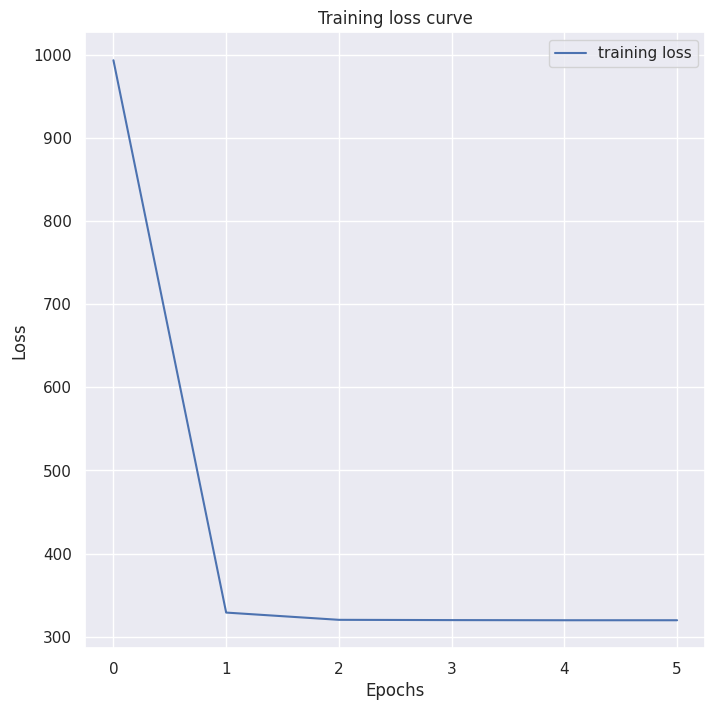

In [ ]:
DNN_app = [train_loss_values[i].cpu().detach().numpy() for i in range(len(train_loss_values))]

plt.figure(figsize = (8, 8))

plt.plot(epoch_count, DNN_app, label = "training loss")

plt.title("Training loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

### LSTM-CNN Approach

In [ ]:
# Prepare the data for sequential modelling

# Drop unused signals
E01 = E1.drop(["angles_glove_4", "angles_glove_5", "angles_glove_8", "angles_glove_12", "angles_glove_16", "angles_glove_20", "angles_glove_21", "angles_glove_22"], axis = 1)
E02 = E2.drop(["angles_glove_4", "angles_glove_5", "angles_glove_8", "angles_glove_12", "angles_glove_16", "angles_glove_20", "angles_glove_21", "angles_glove_22"], axis = 1)

y_train = pd.concat([E01 ,E02])
X_train = pd.concat([emg1, emg2])
st = pd.concat([stimulus1, stimulus2])
print(st.shape)

inall = []
indata = []
outall = []
outdata = []
insti = []

for i in range(stimulus1.shape[0]):
    if (i == 0):
        indata.append(np.array(X_train.iloc[i]))
        outdata.append(np.array(y_train.iloc[i]))
    elif (st.iloc[i].item() != st.iloc[i - 1].item()):
        insti.append(stimulus1.iloc[i - 1])
        inall.append(indata)
        outall.append(outdata)
        indata = []
        outdata = []
        indata.append(np.array(X_train.iloc[i]))
        outdata.append(np.array(y_train.iloc[i]))
    else:
        indata.append(np.array(X_train.iloc[i]))
        outdata.append(np.array(y_train.iloc[i]))

(4361620, 1)


### we can try two approaches padding to the maximum length and the other truncating to the smallest length

In [ ]:
# Determine the maximum sequence length
max_length = max(len(seq) for seq in inall)

# Pad the sequences with zeros
padded_data = []
for seq in inall:
    padded_seq = np.zeros((max_length, seq[0].shape[0]))
    padded_seq[:len(seq)] = seq
    padded_data.append(padded_seq)

# Convert the padded data into a NumPy array
padded_data = np.array(padded_data)

# Verify the shape of the padded data
print(padded_data.shape)

# Save the arrays to files
np.save('X_train_padding.npy', padded_data)

# Determine the maximum sequence length
max_length = max(len(seq) for seq in outall)

# Pad the sequences with zeros
padded_data = []
for seq in outall:
    padded_seq = np.zeros((max_length, seq[0].shape[0]))
    padded_seq[:len(seq)] = seq
    padded_data.append(padded_seq)

# Convert the padded data into a NumPy array
padded_data = np.array(padded_data)

# Verify the shape of the padded data
print(padded_data.shape)

# Save the arrays to files
np.save('y_train_padding.npy', padded_data)

(203, 12246, 12)
(203, 12246, 14)


In [ ]:
# Determine the minimum sequence length
min_length = min(len(seq) for seq in inall)

# Truncate the sequences with excess length
truncated_data = []
for seq in inall:
    truncated_seq = seq[:min_length]
    truncated_data.append(truncated_seq)

# Convert the Truncate data into a NumPy array
truncated_data = np.array(truncated_data)

# Verify the shape of the padded data
print(truncated_data.shape)

# Save the arrays to files
np.save('X_train_truncating.npy', truncated_data)

# Determine the minimum sequence length
min_length = min(len(seq) for seq in outall)

# Truncate the sequences with excess length
truncated_data = []
for seq in outall:
    truncated_seq = seq[:min_length]
    truncated_data.append(truncated_seq)

# Convert the Truncate data into a NumPy array
truncated_data = np.array(truncated_data)

# Verify the shape of the padded data
print(truncated_data.shape)

# Save the arrays to files
np.save('y_train_truncating.npy', truncated_data)

(203, 6498, 12)
(203, 6498, 14)


In [ ]:
# Define the target sequence length
target_length = 10873

# Truncate or pad the sequences accordingly
modified_data = []
for seq in inall:
  if len(seq) > target_length:
    # Truncate the sequence
    modified_seq = seq[:target_length]
  elif len(seq) < target_length:
    # Pad the sequence with zeros
    modified_seq = np.zeros((target_length, seq[0].shape[0]))
    modified_seq[:len(seq)] = seq
  else:
    # Keep the sequence as it is
    modified_seq = seq
  modified_data.append(modified_seq)

# Convert the modified data into a NumPy array
modified_data = np.array(modified_data)

# Verify the shape of the modified data
print(modified_data.shape)

# Save the arrays to files
np.save('x_train_modified.npy', modified_data)

# Define the target sequence length
target_length = 10873

# Truncate or pad the sequences accordingly
modified_data = []
for seq in outall:
  if len(seq) > target_length:
    # Truncate the sequence
    modified_seq = seq[:target_length]
  elif len(seq) < target_length:
    # Pad the sequence with zeros
    modified_seq = np.zeros((target_length, seq[0].shape[0]))
    modified_seq[:len(seq)] = seq
  else:
    # Keep the sequence as it is
    modified_seq = seq
  modified_data.append(modified_seq)

# Convert the modified data into a NumPy array
modified_data = np.array(modified_data)

# Verify the shape of the modified data
print(modified_data.shape)

# Save the arrays to files
np.save('y_train_modified.npy', modified_data)

(203, 10873, 12)
(203, 10873, 14)


In [ ]:
# Define the input shape
input_shape = (12246, 12)

# Define the number of output features
output_features = 14

# Create a custom LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_shape, output_features):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_shape[1], 32, bidirectional = True)           # bidirectional = True
        self.lstm2 = nn.LSTM(64, 128, bidirectional = True)
        self.lstm3 = nn.LSTM(256, 256)
        self.fc_h1 = nn.Linear(256, 512)
        self.fc_h2 = nn.Linear(512, 2048)
        self.fc_h3 = nn.Linear(2048, 4096)
        self.fc_h4 = nn.Linear(4096, 4096)
        self.fc_h5 = nn.Linear(4096, 4096)
        self.fc_h6 = nn.Linear(4096, 1024)
        self.fc_h7 = nn.Linear(1024, 256)
        self.fc = nn.Linear(256, output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.relu(self.fc_h1(x))
        x = self.relu(self.fc_h2(x))
        x = self.relu(self.fc_h3(x))
        x = self.relu(self.fc_h4(x))
        x = self.relu(self.fc_h5(x))
        x = self.relu(self.fc_h6(x))
        x = self.relu(self.fc_h7(x))
        x = self.relu(self.fc(x))
        return x

In [ ]:
# Instantiate the model
model = LSTMModel(input_shape, output_features).to('cuda')

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Load your input and output data
x_train = np.load("X_train_truncating.npy")
y_train = np.load("y_train_truncating.npy")

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

train_data = TensorDataset(x_train, y_train)

batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_loader))

In [ ]:
lstm_app = []
epoch_count = []

# Train the model for 10 epochs
for epoch in range(10):
    train_loss = 0
    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to('cuda'), y_train.to('cuda')

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_train)

        # Compute the loss
        loss = criterion(y_pred, y_train.to(y_pred.device))
        train_loss += loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
    train_loss /= len(train_loader)

    # Print the loss
    print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}')
    lstm_app.append(train_loss)
    epoch_count.append(epoch)

In [ ]:
# Instantiate the model
model = LSTMModel(input_shape, output_features).to('cuda')

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Load your input and output data
x_train = np.load("x_train_modified.npy")
y_train = np.load("y_train_modified.npy")

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

train_data = TensorDataset(x_train, y_train)

batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_loader))

lstm_app = []
epoch_count = []

# Train the model for 10 epochs
for epoch in range(10):
    train_loss = 0
    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to('cuda'), y_train.to('cuda')

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_train)

        # Compute the loss
        loss = criterion(y_pred, y_train.to(y_pred.device))
        train_loss += loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
    train_loss /= len(train_loader)

    # Print the loss
    print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}')
    lstm_app.append(train_loss)
    epoch_count.append(epoch)

In [ ]:
lstm_app = [s.cpu().detach().numpy() for s in lstm_app]

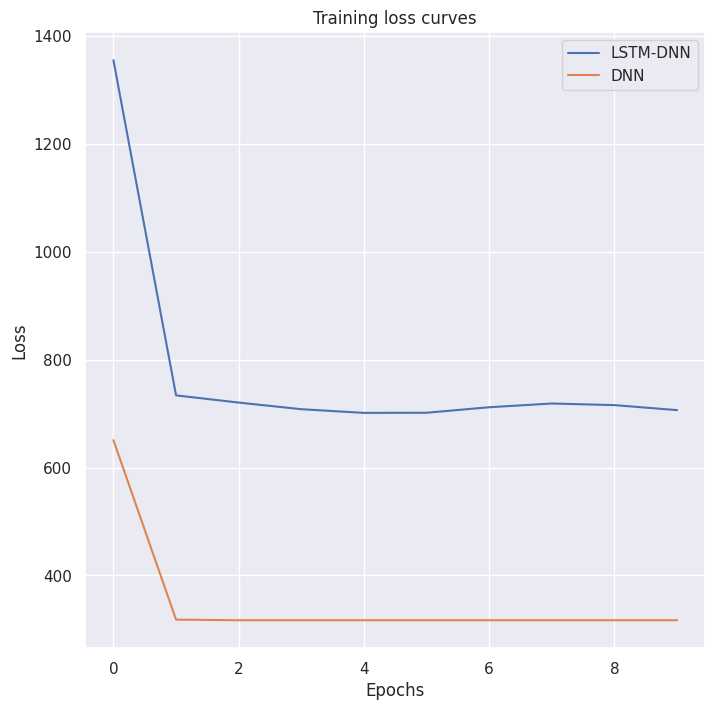

In [ ]:
# Plot the loss curves
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, lstm_app, label = "LSTM-DNN")
plt.plot(epoch_count, DNN_app, label = "DNN")
plt.title("Training loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Create a custom CNN model
class CNNModel(nn.Module):
    def __init__(self, input_shape, output_features):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_shape[1], 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 512, kernel_size=3, padding=1)

        self.fc_h1 = nn.Linear(input_shape[0] * 512,  512)
        self.fc_h2 = nn.Linear(512, 2048)
        self.fc_h3 = nn.Linear(2048, 4096)
        self.fc_h4 = nn.Linear(4096, 4096)
        self.fc_h5 = nn.Linear(4096, 4096)
        self.fc_h6 = nn.Linear(4096, 1024)
        self.fc_h7 = nn.Linear(1024, 256)
        self.fc = nn.Linear(256, output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        print(x.size(0))

        x = self.relu(self.fc_h1(x))
        x = self.relu(self.fc_h2(x))
        x = self.relu(self.fc_h3(x))
        x = self.relu(self.fc_h4(x))
        x = self.relu(self.fc_h5(x))
        x = self.relu(self.fc_h6(x))
        x = self.relu(self.fc_h7(x))
        x = self.relu(self.fc(x))
        return x

# Create a custom LSTM-CNN model
class LSTMCNNModel(nn.Module):
    def __init__(self, input_shape, output_features):
        super(LSTMCNNModel, self).__init__()
        self.lstm = nn.LSTM(input_shape[1], 32)
        self.conv1 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(input_shape[0] * 64, output_features)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model = CNNModel(input_shape, output_features).to('cuda')

cnn_app = []
epoch_count = []

# Train the model for 10 epochs
for epoch in range(10):
    train_loss = 0
    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to('cuda'), y_train.to('cuda')

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_train)

        # Compute the loss
        loss = criterion(y_pred, y_train.to(y_pred.device))
        train_loss += loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
    train_loss /= len(train_loader)

    # Print the loss
    print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}')
    cnn_app.append(train_loss.cpu().detach().numpy())
    epoch_count.append(epoch)

In [ ]:
# Instantiate the model
model = LSTMModel(input_shape, output_features).to('cuda')

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Load your input and output data
x_train = np.load("x_train_modified.npy")
y_train = np.load("y_train_modified.npy")

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

train_data = TensorDataset(x_train, y_train)

batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_loader))

lstm_app = []
epoch_count = []

# Train the model for 10 epochs
for epoch in range(10):
    train_loss = 0
    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to('cuda'), y_train.to('cuda')

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_train)

        # Compute the loss
        loss = criterion(y_pred, y_train.to(y_pred.device))
        train_loss += loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
    train_loss /= len(train_loader)

    # Print the loss
    print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}')
    lstm_app.append(train_loss)
    epoch_count.append(epoch)

51
Epoch: 1, Loss: 1114.9314
Epoch: 2, Loss: 913.8965
Epoch: 3, Loss: 934.9475
Epoch: 4, Loss: 929.2332
Epoch: 5, Loss: 937.7763
Epoch: 6, Loss: 944.0383
Epoch: 7, Loss: 935.8925
Epoch: 8, Loss: 920.5425
Epoch: 9, Loss: 934.9781
Epoch: 10, Loss: 910.0216


## We can try some manifold methods to represent the input data

In [ ]:
# Prepare the data for training

# Merge Excersice 1 and 2
X_train = pd.concat([emg1, emg2])

print(X_train.shape)

X_test1 = X_train.iloc[:200000,:]
X_test2 = X_train.iloc[-200000:,:]
X_test = pd.concat([X_test1, X_test2])

X_train = X_train.iloc[200000:,:].iloc[:-200000,:]

print(X_train.shape)
print(X_test.shape)

# Convert the Dataframe to Tensor
train = torch.tensor(X_train.values.astype(np.float32))
test = torch.tensor(X_test.values.astype(np.float32))

# the input is the same as the output
train_data = TensorDataset(train, train)
test_data = TensorDataset(test, test)

batch_size = 100000
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

(4361620, 12)
(3961620, 12)
(400000, 12)


In [ ]:
# In future we need to use non-linear activation function and see the resulting representation of the data in the latent spcase
# in case using linear activation function the result will be as PCA
class my_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(in_features = 12, out_features = 256)
        self.layer2 = nn.Linear(in_features = 256, out_features = 128)
        self.layer3 = nn.Linear(in_features = 128, out_features = 64)
        self.layer4 = nn.Linear(in_features = 64, out_features = 8)
        self.layer5 = nn.Linear(in_features = 8, out_features = 64)
        self.layer6 = nn.Linear(in_features = 64, out_features = 128)
        self.layer7 = nn.Linear(in_features = 128, out_features = 256)
        self.layer8 = nn.Linear(in_features = 256, out_features = 12)

    def forward(self, inp):
        x = self.relu(self.layer1(inp))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.relu(self.layer7(x))
        x = self.layer8(x)
        return (x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Build and define your model
model = my_model()
model.to(device)

# Define the Loss function and the Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters())

# Specify the number of epochs
epochs = 10

# Instantiate lists to save the loss values during the training process
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    # Training mode
    model.train()

    train_x = train.to(device)
    train_y = train.to(device)

    # Feedforward
    y_pred = model(train_x)

    # At the start of each ****** Epoch
    optimizer.zero_grad()

    # Calculate the loss function
    train_loss = loss_fn(y_pred, train_y)

    # Do the back probagation and update the parameters
    train_loss.backward()
    optimizer.step()

    # Evaluation mode
    model.eval()

    with torch.inference_mode():

        test_x, test_y = test.to(device), test.to(device)

        # Feedforward again for the evaluation phase
        y_pred_test = model(test_x)

        # Calculate the loss for the test dataset
        loss_test = loss_fn(y_pred_test, test_y)

    # Append loss values for the training process
    train_loss_values.append(train_loss.cpu().detach().numpy())
    test_loss_values.append(loss_test.cpu().detach().numpy())
    epoch_count.append(epoch)
    print(f"Epoch : {epoch + 1} | train_Loss: {train_loss} | test_Loss: {loss_test}")

In [ ]:
# Plot the loss curves
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, train_loss_values, label = "training loss")
plt.plot(epoch_count, test_loss_values, label = "testing loss")
plt.title("Training and Test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
class my_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(in_features = 12, out_features = 256)
        self.layer2 = nn.Linear(in_features = 256, out_features = 128)
        self.layer3 = nn.Linear(in_features = 128, out_features = 64)
        self.layer4 = nn.Linear(in_features = 64, out_features = 8)
        self.layer5 = nn.Linear(in_features = 8, out_features = 64)
        self.layer6 = nn.Linear(in_features = 64, out_features = 128)
        self.layer7 = nn.Linear(in_features = 128, out_features = 256)
        self.layer8 = nn.Linear(in_features = 256, out_features = 12)

    def forward(self, inp):
        x = self.relu(self.layer1(inp))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.relu(self.layer7(x))
        x = self.layer8(x)
        return (x)

# Build and define your model
model = my_model()
model.to(device0)
model = nn.DataParallel(model)

# Define the Loss function and the Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters())

# Specify the number of epochs
epochs = 10

# Instantiate lists to save the loss values during the training process
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    # Training mode
    model.train()

    # Feedforward
    y_pred = model(train.to(device0))

    # At start of each Epoch
    optimizer.zero_grad()

    # Calculate the loss function
    loss = loss_fn(y_pred, train.to(device0))

    # Do the back probagation and update the parameters
    loss.backward()
    optimizer.step()

    # Evaluation mode
    model.eval()

    with torch.inference_mode():

        # Feedforward again for the evaluation phase
        y_pred_test = model(test.to(device0))

        # Calculate the loss for the test dataset
        loss_test = loss_fn(y_pred_test, test.to(device0))

    # Append loss values for the training process
    train_loss_values.append(loss.cpu().detach().numpy())
    test_loss_values.append(loss_test.cpu().detach().numpy())
    epoch_count.append(epoch)
    print(f"Epoch : {epoch + 1} | train_Loss: {loss} | test_Loss: {loss_test}")

tensor(4)

In [ ]:
torch.tanh(torch.tensor(1))

tensor(0.7616)

In [ ]:
class my_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(in_features = 12, out_features = 256)
        self.layer2 = nn.Linear(in_features = 256, out_features = 128)
        self.layer3 = nn.Linear(in_features = 128, out_features = 64)
        self.layer4 = nn.Linear(in_features = 64, out_features = 2)
        self.layer5 = nn.Linear(in_features = 2, out_features = 64)
        self.layer6 = nn.Linear(in_features = 64, out_features = 128)
        self.layer7 = nn.Linear(in_features = 128, out_features = 256)
        self.layer8 = nn.Linear(in_features = 256, out_features = 12)
        self.encoder = nn.Sequential(
            self.layer1,
            self.relu,
            self.layer2,
            self.relu,
            self.layer3,
            self.relu,
            self.layer4,
            self.relu,
        )
        self.decoder = nn.Sequential(
            self.layer5,
            self.relu,
            self.layer6,
            self.relu,
            self.layer7,
            self.relu,
            self.layer8,
            self.relu,
        )
    def forward(self, inp):
        # x = self.relu(self.layer1(inp))
        # x = self.relu(self.layer2(x))
        # x = self.relu(self.layer3(x))
        # x = self.relu(self.layer4(x))
        # x = self.relu(self.layer5(x))
        # x = self.relu(self.layer6(x))
        # x = self.relu(self.layer7(x))
        # x = self.layer8(x)
        x = self.encoder(inp)
        x = self.decoder(x)
        return (x)

device0 = 'cuda'

# Build and define your model
model = my_model()
model.to(device0)
model = nn.DataParallel(model)

# Define the Loss function and the Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters())

# Specify the number of epochs
epochs = 10

# Instantiate lists to save the loss values during the training process
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    train_loss = 0
    for train_x, train_y in train_loader:

        train_x, train_y = train_x.to(device0), train_y.to(device0)
        # Training mode
        model.train()

        # Feedforward
        y_pred = model(train_x)

        # At start of each Epoch
        optimizer.zero_grad()

        # Calculate the loss function
        loss = loss_fn(y_pred, train_y)
        train_loss += loss

        # Do the back probagation and update the parameters
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Evaluation mode
    model.eval()

    loss_test = 0
    with torch.inference_mode():
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device0), test_y.to(device0)

            # Feedforward again for the evaluation phase
            y_pred_test = model(test_x)

            # Calculate the loss for the test dataset
            loss_test += loss_fn(y_pred_test, test_y)

        loss_test /= len(test_loader)

    # Append loss values for the training process
    train_loss_values.append(loss.cpu().detach().numpy())
    test_loss_values.append(loss_test)
    epoch_count.append(epoch)
    print(f"Epoch : {epoch + 1} | train_Loss: {loss} | test_Loss: {loss_test}")

In [ ]:
coding = model.module.encoder(train.to('cuda'))

In [ ]:
coding[:][0]

In [ ]:
# Plot the loss curves
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, train_loss_values, label = "training loss")
plt.plot(epoch_count, test_loss_values, label = "testing loss")
plt.title("Training and Test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plot the loss curves
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, train_loss_values, label = "training loss")
plt.plot(epoch_count, test_loss_values, label = "testing loss")
plt.title("Training and Test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(emg1)
plt.figure(figsize = (8, 8))
plt.bar(range(1, len(pca.explained_variance_ratio_) +  1), pca.explained_variance_ratio_)
plt.xlabel("NO.Components")
plt.ylabel("Variance Captured by each component")
plt.title("Variance Explained")
plt.show()

var_cum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (8, 8))
plt.bar(range(1, len(var_cum) + 1), var_cum)
plt.xlabel("NO.Components")
plt.ylabel("Variance Captured by these number of components")
plt.title("Cumulative Variance Explained")
plt.show()

print(sum(var_cum < 0.99))  # 9 component
print(sum(var_cum < 0.95))  # 7 component